In [1]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

BATCH_SIZE = 100
NUM_WORKERS = 8

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class WTA(nn.Module):
    # https://github.com/iwyoo/tf_ConvWTA/blob/master/model.py
    def __init__(self):
        super(WTA, self).__init__()

        self.enc = nn.Sequential(
            # input is Z, going into a convolution
            nn.Conv2d(1, 128, 5, 1, 2),
            nn.ReLU(True),
            nn.Conv2d(128, 128, 5, 1, 2),
            nn.ReLU(True),
            nn.Conv2d(128, 16, 5, 1, 2),
            nn.ReLU(True),
        )
        
        self.dec = nn.ConvTranspose2d(16, 1, 11, 1, 5)

    def encode(self, x):
        h = self.enc(x.view(-1, 1, 28, 28))
        return h
    
    def decode(self, z):
        return self.dec(z)

    def spatial_sparsity(self, h):
        n = h.shape[0]
        c = h.shape[1]
        h_reshape = h.reshape(n,c,-1)
        thr, ind = torch.topk(h_reshape, 1, dim=-1)
        mask = torch.where(h<thr.min(), torch.zeros(1).to(device), torch.ones(1).to(device))
        return h*mask
    
    def lifetime_sparsity(self, h, rate=0.05):
        n = h.shape[0]
        c = h.shape[1]
        h_reshape, _ = h.reshape(n,c,-1).max(dim=-1)
        thr, ind = torch.topk(h_reshape, int(rate*n), dim=0)
        mask = torch.where(h<thr.min(), torch.zeros(1).to(device), torch.ones(1).to(device))
        return h*mask

    def forward(self, x):
        z = self.encode(x)
        z = self.spatial_sparsity(z)
        if self.training:
            z = self.lifetime_sparsity(z)
        out = self.decode(z)
        return out

loss_function = torch.nn.MSELoss()

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader)))


def eval(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_loss += loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                           'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


In [2]:
def mnist_subset(dataset, classes_to_use):
    # dataset: datasets.MNIST('./', train=False, transform=transforms.ToTensor())
    # classes_to_use: a list of class
    data = dataset.data.numpy()
    targets = dataset.targets.numpy()

    data_to_keep = []
    targets_to_keep = []
    for i in range(len(targets)):
        if targets[i] in classes_to_use:
            data_to_keep.append(data[i])
            targets_to_keep.append(targets[i])

    dataset.data = torch.tensor(np.stack(data_to_keep, axis=0))
    dataset.targets = torch.tensor(np.array(targets_to_keep))
    return dataset

In [3]:
def DKL_gau(mu1, std1, mu2, std2):
    # https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
    return torch.log(std2/std1)+(std1.pow(2) + (mu1-mu2).pow(2)) / (2*std2.pow(2)) - 0.5

def recon_till_converge(image_batch, thres=1e-6, return_history=False):
    diff=1e10
    history = [image_batch]
    model.eval()
    with torch.no_grad():
        while diff>thres:
            recon_batch = model(image_batch)
            diff = torch.mean((recon_batch - recon_batch).pow(2))
            if return_history:
                history.append(recon_batch)
            image_batch = recon_batch
    if return_history:
        return recon_batch, history
    else:
        return recon_batch


In [4]:
batch_size=BATCH_SIZE
epochs=10
log_interval=10
seed=1
cuda=True
classes_to_use = [0,1,2,3,4,5,6,7,8,9]

torch.manual_seed(seed)

device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': NUM_WORKERS, 'pin_memory': True} if cuda else {}

In [5]:
model = WTA().to(device)
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
train_dataset = datasets.MNIST('./', train=True, download=True,transform=transforms.ToTensor())
train_dataset = mnist_subset(train_dataset, classes_to_use)
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, **kwargs)

# test_dataset = datasets.MNIST('./', train=False, transform=transforms.ToTensor())
# test_dataset = mnist_subset(test_dataset, classes_to_use)
# test_loader = torch.utils.data.DataLoader(test_dataset,
#     batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [7]:
for epoch in range(1, epochs + 1):
    train(epoch)
    eval(epoch)

====> Epoch: 1 Average loss: 0.0078
====> Test set loss: 0.0000
====> Epoch: 2 Average loss: 0.0002
====> Test set loss: 0.0000
====> Epoch: 3 Average loss: 0.0002
====> Test set loss: 0.0000
====> Epoch: 4 Average loss: 0.0001
====> Test set loss: 0.0000
====> Epoch: 5 Average loss: 0.0001
====> Test set loss: 0.0000
====> Epoch: 6 Average loss: 0.0002
====> Test set loss: 0.0000
====> Epoch: 7 Average loss: 0.0001
====> Test set loss: 0.0000
====> Epoch: 8 Average loss: 0.0001
====> Test set loss: 0.0000
====> Epoch: 9 Average loss: 0.0001
====> Test set loss: 0.0000
====> Epoch: 10 Average loss: 0.0001
====> Test set loss: 0.0000


Digits that are not

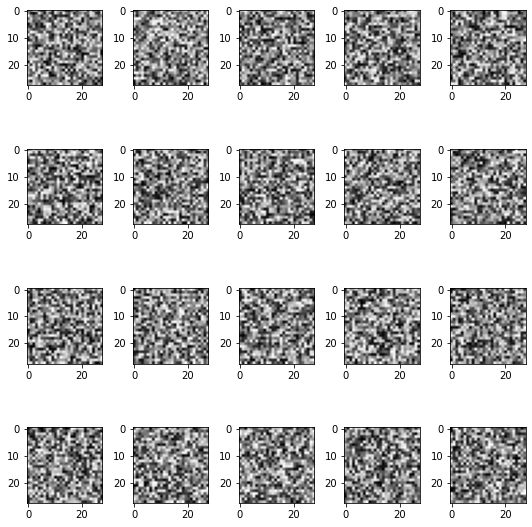

In [8]:
sample = torch.rand((20,28,28)) #TODO: what noise？
#TODO：有没有double ascend？
num_row = 4
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(20):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(sample[i].cpu().numpy().reshape(28,28), cmap='gray')
plt.tight_layout()
plt.show()

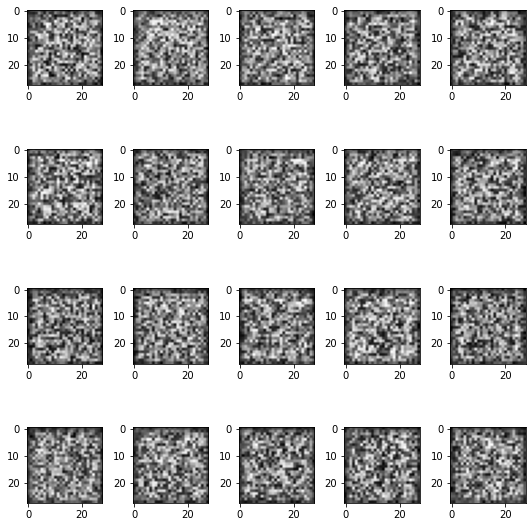

In [9]:
num_row = 4
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(20):
    ax = axes[i//num_col, i%num_col]
    converged_image = recon_till_converge(sample[i:i+1].to(device), thres=1e-5)
    ax.imshow(converged_image[0].cpu().numpy().reshape(28,28), cmap='gray')
plt.tight_layout()
plt.show()

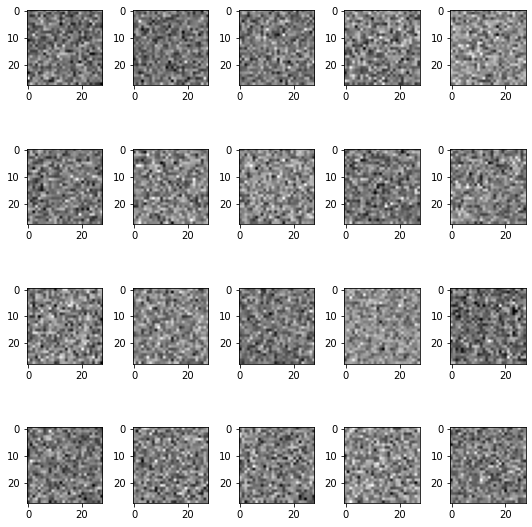

In [10]:
sample = torch.randn((20,28,28))
#TODO：有没有double ascend？
num_row = 4
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(20):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(sample[i].cpu().numpy().reshape(28,28), cmap='gray')
plt.tight_layout()
plt.show()

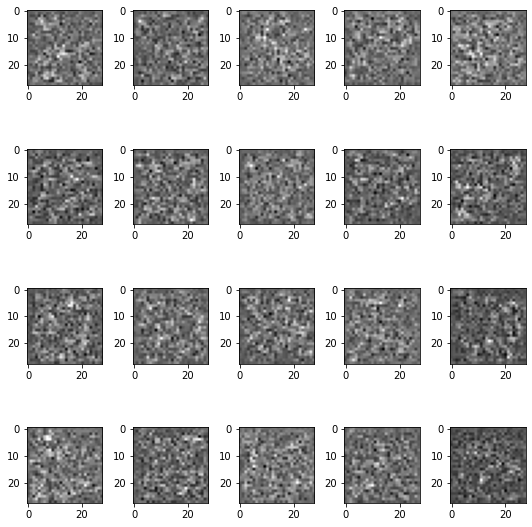

In [11]:
num_row = 4
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(20):
    ax = axes[i//num_col, i%num_col]
    converged_image = recon_till_converge(sample[i:i+1].to(device), thres=1e-5)
    ax.imshow(converged_image[0].cpu().numpy().reshape(28,28), cmap='gray')
plt.tight_layout()
plt.show()

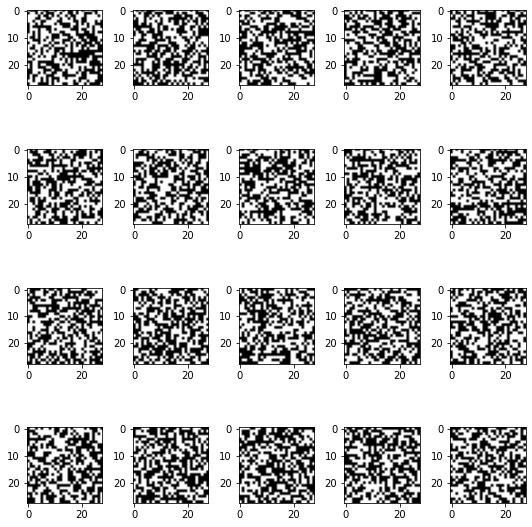

In [12]:
sample = torch.randint(0, 2, (20,28,28)).float()
#TODO：有没有double ascend？
num_row = 4
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(20):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(sample[i].cpu().numpy().reshape(28,28), cmap='gray')
plt.tight_layout()
plt.show()

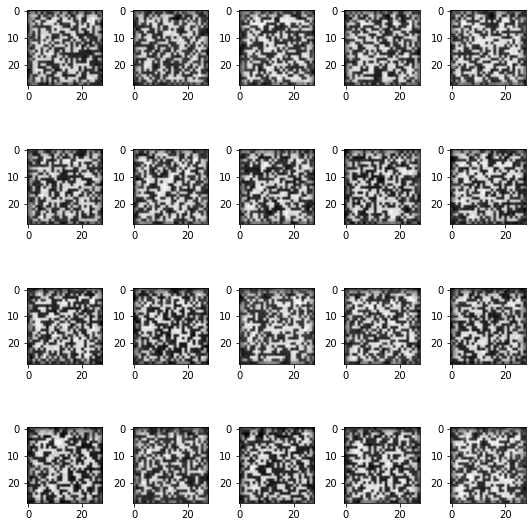

In [13]:
num_row = 4
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(20):
    ax = axes[i//num_col, i%num_col]
    converged_image = recon_till_converge(sample[i:i+1].to(device), thres=1e-5)
    ax.imshow(converged_image[0].cpu().numpy().reshape(28,28), cmap='gray')
plt.tight_layout()
plt.show()

## Reconstruction

In [14]:
with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.to(device)
        recon_batch = model(data)


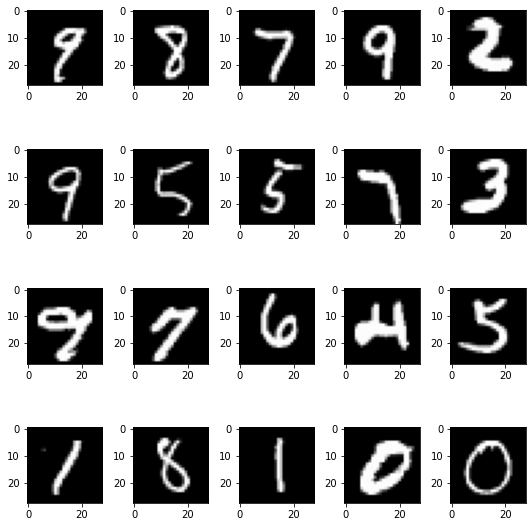

In [15]:
num_row = 4
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(20):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(data[i].cpu().numpy().reshape(28,28), cmap='gray')
plt.tight_layout()
plt.show()

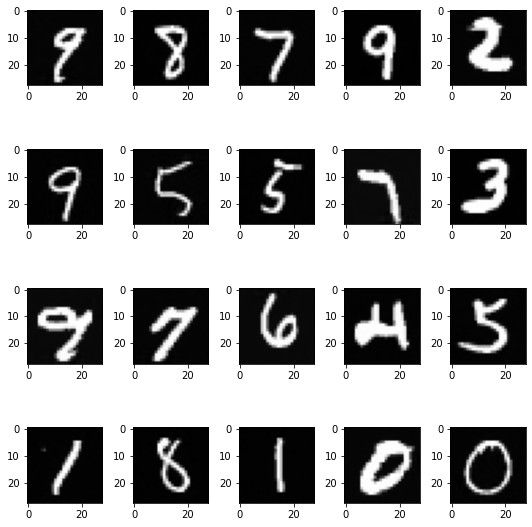

In [16]:
num_row = 4
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(20):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(recon_batch[i].cpu().numpy().reshape(28,28), cmap='gray')
plt.tight_layout()
plt.show()